In [1]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def get_gp(X, y, alpha=10**-2, kernel_name='const_rbf', seed = 1234, length_scale = 1.):
    kernel = ConstantKernel() * RBF(length_scale_bounds=[1e-5, 100.0], length_scale = length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=alpha, random_state=seed)
    gp.fit(X, y.ravel())
    return gp

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
samplespec = {
    'name': 'hello',
    'data': [0,0,0,0,0,0],
    'modifiers': [
        {
        'name': 'mygp',
        'type': 'gpsys',
        'data': {
            'kernel': 'rbf_constant',
            'evals': [ #(sample bin, alphaval, delta)
                 [ 3, 0.5,-1.0, 25.0],
                 [ 5,-0.2, 0.8, 20.0],

                 [ 1, 0.0, 0.0, 25.0], #nom
#                  [ 3, 0.0, 0.0, 14.0], #nom
                 [ 5, 0.0, 0.0, 30.0], #nom

                 [ 0,-1.0,-0.2, 30.0],
                 [ 5, 0.4, 0.9, 27.0],
                ]
            }
        }
    ]
}

In [4]:
modspec = samplespec['modifiers'][0]
Xy = np.asarray(modspec['data']['evals'])
X,y = Xy[:,:3], Xy[:,3]
gp = get_gp(X,y)
# Xy

In [5]:
from mpl_toolkits.mplot3d import Axes3D

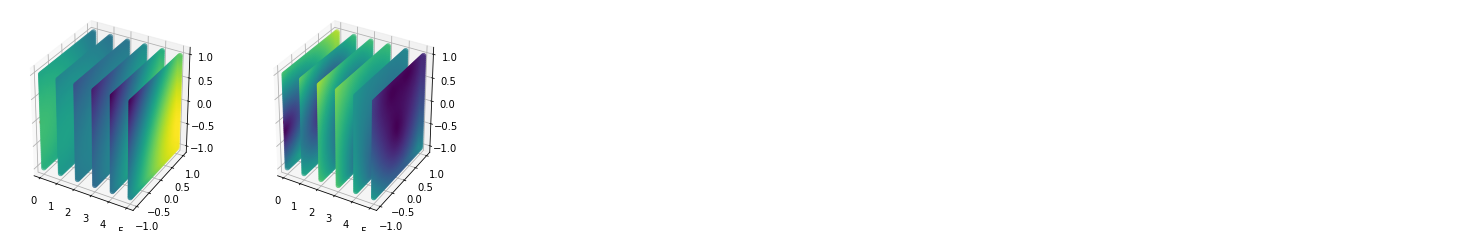

In [8]:
Xinterp = np.mgrid[0:5:6j,-1:1:51j,-1:1:51j]
Xinterp = np.einsum('abcd->bcda',Xinterp)
Xinterp = Xinterp.reshape(6*51*51,3)

y,err = gp.predict(Xinterp, return_std=True)

f, axarr = plt.subplots(1,2, subplot_kw= {'projection': '3d'})

ax = axarr[0]
ax.scatter(Xinterp[:,0],Xinterp[:,1],Xinterp[:,2], c = y)
ax.scatter(X[:,0],X[:,1], c='r')


ax = axarr[1]
ax.scatter(Xinterp[:,0],Xinterp[:,1],Xinterp[:,2], c = err)
ax.scatter(X[:,0],X[:,1], c='r')
f.set_size_inches(8,4)

In [9]:
def interpolate(alphas,gammas):
    nbins = 6
    auxdata_deltas =  np.zeros(nbins,)
    auxdata_alphas =  0.0
    
    X = np.arange(nbins).reshape(-1,1)
    X = np.concatenate([X,np.ones_like(X)*alphas[0],np.ones_like(X)*alphas[1]],axis=1)
    mean,cov = gp.predict(X, return_cov= True)

    gammas = np.asarray(gammas)
    deltas = (gammas-1)*mean
    
    return mean+deltas


In [10]:
interpolate([0.0,1.0],[1,1,1,1,1,1])

array([25.08347447, 22.22333561, 18.64083079, 17.18275735, 18.52076092,
       20.6695977 ])

In [11]:
import scipy.stats
def plot_modifier(samplespec,a0,a1,g0,g1,g2,g3,g4,g5):
    nbins = 6
    auxdata_deltas =  np.zeros(nbins,)
    auxdata_alphas =  [0.0,0.0]

    input_data = np.asarray(samplespec['modifiers'][0]['data']['evals'])

    
    gammas = np.asarray([g0,g1,g2,g3,g4,g5])

    f,axarr = plt.subplots(1,3)
    f.set_size_inches(12,4)
    
    X = np.arange(nbins).reshape(-1,1)
    alphas = [a0,a1]

    at_alphas = np.einsum('o,a->oa',np.ones((X.shape[0],)),alphas)
    X = np.concatenate([X,at_alphas],axis=1)
   
    mean,err = gp.predict(X, return_std= True)
    deltas = (gammas-1)*mean
    
    ax = axarr[0]
    ax.set_title('delta constraints')
    ax.set_ylim(-10,10)
    ax.fill_between(X[:,0],-err,err, facecolor = 'grey', alpha = 0.2)
    ax.scatter(X[:,0],auxdata_deltas, c = 'k')
    ax.scatter(X[:,0],deltas, c = 'r')

    
    ax = axarr[1]
    ax.set_title('alpha constraint')


    A = np.mgrid[-1:1:101j,-1:1:101j]
    A = np.einsum('abc->bca',A)
    A = A.reshape(101*101,2)
        
    pdf = scipy.stats.multivariate_normal(alphas,[[1.,0],[0,1.]])
    
    z = pdf.pdf(A)
    z = z.reshape(101,101)
    x,y = np.mgrid[-1:1:101j,-1:1:101j]
    ax.scatter(x,y,c = z, cmap = 'binary')
    ax.scatter(auxdata_alphas[0],auxdata_alphas[1], c = 'w')
    ax.scatter(alphas[0],alphas[1], c = 'r')

    ax.scatter(input_data[:,1],input_data[:,2], alpha = 0.8, c = 'b')
        
    nom = samplespec['data']
    
    ax = axarr[2]
    ax.set_title('channel')
    ax.scatter(np.arange(nbins),nom, c = 'k')
    ax.plot(np.arange(nbins),nom, c = 'k')
    ax.plot(np.arange(nbins),nom + mean, c = '#444444', linestyle = 'dashed', alpha = 0.1)
    ax.scatter(np.arange(nbins),nom + mean + deltas, c = 'r')
    ax.plot(np.arange(nbins),nom + mean + deltas, c = 'r')
    ax.fill_between(np.arange(nbins),nom + mean -err, nom + mean + err, facecolor = 'grey', alpha = 0.1)

    ax.scatter(input_data[:,0],input_data[:,-1], alpha = 0.2, c = 'blue')
    
    ax.set_ylim(0,50.)

In [12]:
from ipywidgets import interact,fixed
kwargs = {'g{}'.format(i): (0.5,1.5,0.1) for i in range(6)}
interact(plot_modifier,a0 = (-1,1,0.1), a1 = (-1,1,0.05), samplespec = fixed(samplespec),**kwargs)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.plot_modifier(samplespec, a0, a1, g0, g1, g2, g3, g4, g5)>

In [ ]:
plot_modifier(samplespec,-0.3,0.4,1.1,0.95,1.10,1.05,1.15,0.9)
plt.gcf().savefig('img/gpsys.png')

In [786]:
%%timeit
interpolate([0.0,1.0],[1,1,1,1,1,1])

309 µs ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
